In [1]:
import pandas as pd
!pip install py7zr
import py7zr
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD,Adam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.8/413.8 kB 20.1 MB/s eta 0:00:00


2024-06-27 07:06:49.793261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 07:06:49.793447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 07:06:49.939003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
with py7zr.SevenZipFile('/kaggle/input/statoil-iceberg-classifier-challenge/train.json.7z', mode='r') as z:
    z.extractall()
    
with py7zr.SevenZipFile('/kaggle/input/statoil-iceberg-classifier-challenge/test.json.7z', mode='r') as z1:
    z1.extractall()
    
# with py7zr.SevenZipFile('/kaggle/input/statoil-iceberg-classifier-challenge/sample_submission.csv.7z', mode='r') as z2:
#     z2.extractall()

In [3]:
train = pd.read_json('/kaggle/working/data/processed/train.json')
test = pd.read_json('/kaggle/working/data/processed/test.json')
train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [4]:
import numpy as np
def get_scaled_imgs(df):
    imgs = []

    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)

        #将图像归一化到 0-1 的范围，使用归一化公式
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())
        imgs.append(np.dstack((a, b, c)))
    return np.array(imgs)

In [5]:
#数据从 DataFrame 中存储图像信息
data = get_scaled_imgs(train)
#target把模型学习并用来预测的那些目标值Numpy array里
target = np.array(train['is_iceberg'])

In [6]:
print(data.shape)
print(target[:20])

(1604, 75, 75, 3)
[0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1]


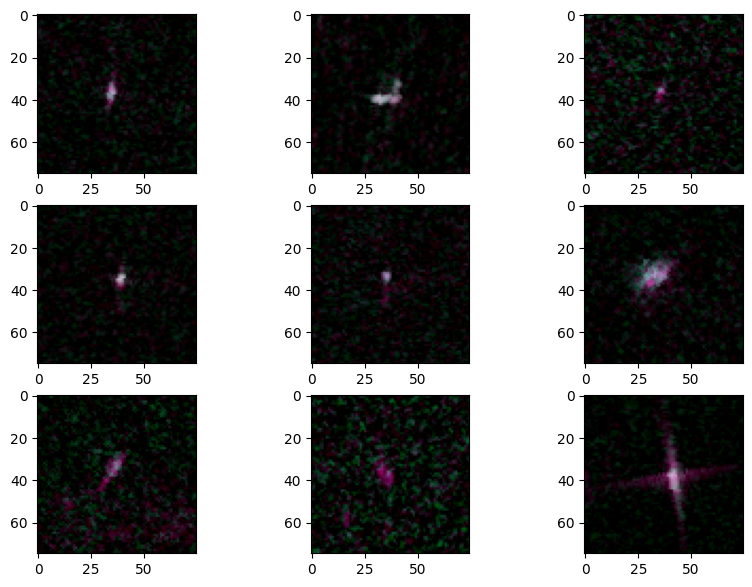

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 7))
rows = 3
columns = 3

#循环添加子图到图形上
for i in range(9):
    #在位置 i+1 添加子图
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(data[i])

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,target,test_size=0.2,random_state=1)

In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_train[0])

(1283, 75, 75, 3)
(1283,)
(321, 75, 75, 3)
(321,)
[[[-0.0113155   0.11834145  0.05236127]
  [ 0.10425804  0.09274388  0.11942784]
  [-0.02106929  0.24036991  0.1076804 ]
  ...
  [-0.02118661  0.09258171  0.03241646]
  [-0.00192844  0.14257895  0.07119625]
  [-0.16280689  0.00732008 -0.10909579]]

 [[ 0.08224537 -0.27087956 -0.08080829]
  [ 0.12507859  0.00748442  0.09048268]
  [ 0.11132134  0.16605811  0.1616188 ]
  ...
  [ 0.05067076  0.11817693  0.09523195]
  [ 0.03392232  0.07929773  0.06384726]
  [-0.05201566 -0.00834081 -0.04028822]]

 [[-0.13516442 -0.05817352 -0.12325832]
  [-0.08540454  0.00748442 -0.05537499]
  [ 0.05078653  0.07945772  0.07561498]
  ...
  [-0.12222751 -0.00833616 -0.08894027]
  [-0.00192844 -0.1334083  -0.06920366]
  [-0.01143965 -0.05834034 -0.03760612]]

 ...

 [[-0.02108259  0.23035906  0.10257848]
  [-0.02108427  0.11831632  0.04557906]
  [-0.00182611 -0.07598326 -0.03991955]
  ...
  [ 0.08210956  0.10551249  0.11057533]
  [ 0.11118704  0.09255647  0.1241

In [10]:
model = Sequential()

    # CNN 1
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Dropout(0.2))

    # CNN 2
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

    # CNN 3
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

    # CNN 4
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

    #将输入数据转换为向量以供Dense层使用
model.add(Flatten())

    # Dense 1 或全连接层
model.add(Dense(512, activation='relu',input_shape=(257,)))
model.add(Dropout(0.2))

    # Dense 2
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

    # Output
model.add(Dense(1, activation="sigmoid"))

# Final model
optimizer = Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,193 (2.14 MB)

 Trainable params: 560,193 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
import keras 

file_path = "weights_best.keras"

checkpoint = keras.callbacks.ModelCheckpoint(file_path, monitor="val_accuracy", save_best_only=True, mode='max')

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.9, patience=2, min_lr=1e-6, mode="max", verbose=True)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="max", verbose=True)

callbacks_list = [checkpoint, reduce_lr, early_stopping]

In [12]:
history = model.fit(x_train,y_train,batch_size=10,epochs=100,verbose=1,validation_split=0.2,callbacks=callbacks_list)

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.5282 - loss: 0.6930 - val_accuracy: 0.5447 - val_loss: 0.6839 - learning_rate: 1.0000e-04
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.5222 - loss: 0.6808 - val_accuracy: 0.6459 - val_loss: 0.6452 - learning_rate: 1.0000e-04
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.6288 - loss: 0.6240 - val_accuracy: 0.7237 - val_loss: 0.5585 - learning_rate: 1.0000e-04
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 0.6831 - loss: 0.5526 - val_accuracy: 0.7043 - val_loss: 0.5334 - learning_rate: 1.0000e-04
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.7971 - loss: 0.4486 - val_accuracy: 0.7704 - val_loss: 0.4558 - learning_rate: 1.0000e-04
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.8001 - loss: 0.4108 - val_accuracy: 0.7626 - val_loss: 0.4448 - learning_rate: 1.0000e-04
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━

In [13]:
df_his = pd.DataFrame.from_dict(history.history)
history.params
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

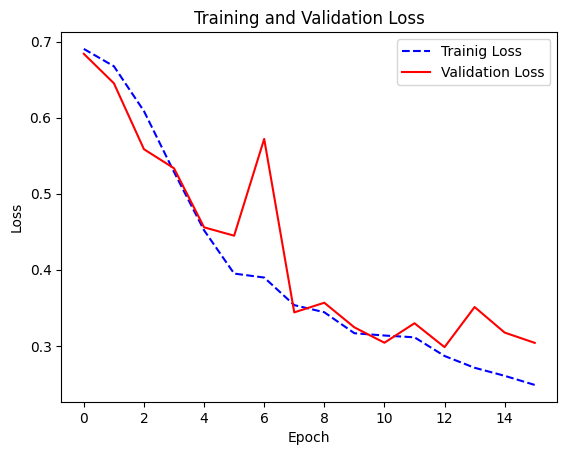

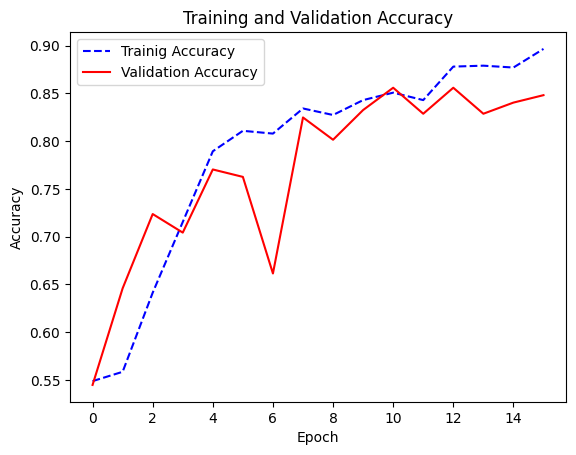

In [14]:
#训练数据集损失值的图表
df_his['loss'].plot(style='b--',label='Trainig Loss')
#验证数据集损失值的图表
df_his['val_loss'].plot(style='r-',label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.legend()
plt.show()

df_his['accuracy'].plot(style='b--',label='Trainig Accuracy')
df_his['val_accuracy'].plot(style='r-',label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.legend()
plt.show()

In [15]:
#加载模型
file_path = "./weights_best.keras"
model = keras.models.load_model(file_path)

In [16]:
#使用模型
predicted = model.predict(x_test)
print(predicted[:5])

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
[[4.0878929e-04]
 [7.7443672e-03]
 [8.6539471e-01]
 [2.2181862e-03]
 [8.9387012e-01]]


In [17]:
#使用测试数据集评估的模型的损失值和准确率
score = model.evaluate(x_test,y_test,verbose=0)
print("Test Loss:",score[0])
print("Accuracy:",score[1])

Test Loss: 0.2640935480594635
Accuracy: 0.8691588640213013


In [18]:
test.head()

,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.966400
1,4023181e,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",32.615072
2,b20200e4,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",37.505433
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.473900
4,4371c8c3,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",43.918874


In [19]:
test_data = get_scaled_imgs(test)
test_data.shape

(8424, 75, 75, 3)

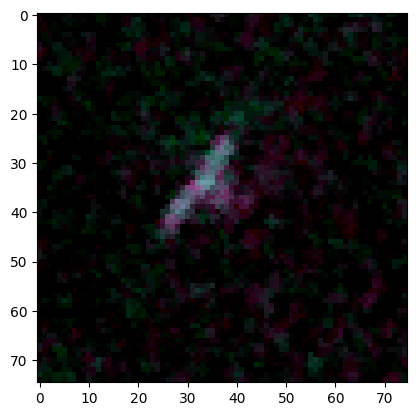

In [20]:
plt.imshow(test_data[3])

In [21]:
predicted = model.predict(test_data)
print(predicted[:10])

264/264 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step
[[0.6046228 ]
 [0.3765106 ]
 [0.08669174]
 [0.9742197 ]
 [0.31218743]
 [0.29174277]
 [0.04748124]
 [0.9727613 ]
 [0.00128557]
 [0.00755316]]


In [22]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['is_iceberg'] = predicted.reshape((predicted.shape[0]))
submission.to_csv('iceberg.csv', index = False)
submission

,id,is_iceberg
0,5941774d,0.604623
1,4023181e,0.376511
2,b20200e4,0.086692
3,e7f018bb,0.974220
4,4371c8c3,0.312187
...,...,...
8419,16ee9b50,0.007108
8420,5a599eb7,0.221997
8421,df30d6dd,0.303825
8422,18af95b1,0.956203


In [23]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'iceberg.csv')

/kaggle/working/iceberg.csv